In [14]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora, models

In [15]:
import os
os.environ['JAVAHOME'] = 'C:/Program Files/Java/jdk-17.0.1/bin'
os.environ['STANFORD_PARSER'] = 'C:/stanford-corenlp-4.5.3'
os.environ['STANFORD_MODELS'] = 'C:/stanford-corenlp-4.5.3'


In [16]:
from nltk.parse import CoreNLPParser

pos_tagger = CoreNLPParser(url='http://localhost:9000', tagtype='pos')

### Domain Dictionary

In [17]:
dict1 = pd.read_csv("suicidal_indicator.csv", header=None).T
dict2 = pd.read_csv("suicidal_ideation.csv", header=None).T
dict3 = pd.read_csv("suicidal_behavior.csv", header=None).T
dict4 = pd.read_csv("suicidal_attempt.csv", header=None).T


In [18]:
###combined dictionary into 1
domain_dict = pd.concat([dict1, dict2, dict3,dict4], ignore_index=True)
domain_dict = domain_dict.rename(columns={0: 'lexicons'})
domain_dict.head()

,lexicons
0,Pessimistic character
1,Suicide of relative
2,Family history of suicide
3,Suicide of close relative
4,Suicide risk assessment


In [19]:
def lower_text(text):
    text = str(text).lower()
    return text

In [20]:
domain_dict['lexicons'] = domain_dict['lexicons'].apply(lower_text)

In [21]:
domain_dict

,lexicons
0,pessimistic character
1,suicide of relative
2,family history of suicide
3,suicide of close relative
4,suicide risk assessment
...,...
2272,went in the freezer
2273,jumped from bridge
2274,jumped from roof
2275,bag around head


In [22]:
domain_dict = domain_dict.drop(domain_dict.index[1521]).reset_index(drop=True)

In [23]:
def stem_preprocess_text(sentence):
    stop_words = set(stopwords.words('english'))
    stemmer = SnowballStemmer('english')
    sentence = str(sentence)
    words = nltk.word_tokenize(sentence.lower())
    tagged_words = pos_tagger.tag(words)
    tagged_words = [(stemmer.stem(word), tag) for word, tag in tagged_words if word not in stop_words]
    return tagged_words

In [24]:
domain_dict["stem"] = domain_dict["lexicons"].apply(stem_preprocess_text)

In [25]:
def lem_preprocess_text(sentence):
    stop_words = set(stopwords.words('english'))
#     stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    sentence = str(sentence)
    words = nltk.word_tokenize(sentence.lower())
    tagged_words = pos_tagger.tag(words)
    tagged_words = [(lemmatizer.lemmatize(word), tag) for word, tag in tagged_words if word not in stop_words]
    return tagged_words

In [26]:
domain_dict["lem"] = domain_dict["lexicons"].apply(lem_preprocess_text)

In [27]:
domain_dict

,lexicons,stem,lem
0,pessimistic character,"[(pessimist, JJ), (charact, NN)]","[(pessimistic, JJ), (character, NN)]"
1,suicide of relative,"[(suicid, NN), (relat, JJ)]","[(suicide, NN), (relative, JJ)]"
2,family history of suicide,"[(famili, NN), (histori, NN), (suicid, NN)]","[(family, NN), (history, NN), (suicide, NN)]"
3,suicide of close relative,"[(suicid, NN), (close, JJ), (relat, JJ)]","[(suicide, NN), (close, JJ), (relative, JJ)]"
4,suicide risk assessment,"[(suicid, NN), (risk, NN), (assess, NN)]","[(suicide, NN), (risk, NN), (assessment, NN)]"
...,...,...,...
2271,went in the freezer,"[(went, VBD), (freezer, NN)]","[(went, VBD), (freezer, NN)]"
2272,jumped from bridge,"[(jump, VBD), (bridg, NN)]","[(jumped, VBD), (bridge, NN)]"
2273,jumped from roof,"[(jump, VBD), (roof, NN)]","[(jumped, VBD), (roof, NN)]"
2274,bag around head,"[(bag, NN), (around, IN), (head, NN)]","[(bag, NN), (around, IN), (head, NN)]"


In [28]:
def nested_list_to_string(nested_list):
    return ' '.join(['_'.join(tup) for tup in nested_list])

In [29]:
domain_dict["stem"] = domain_dict["stem"].apply(nested_list_to_string)
domain_dict["lem"] = domain_dict["lem"].apply(nested_list_to_string)
domain_dict

,lexicons,stem,lem
0,pessimistic character,pessimist_JJ charact_NN,pessimistic_JJ character_NN
1,suicide of relative,suicid_NN relat_JJ,suicide_NN relative_JJ
2,family history of suicide,famili_NN histori_NN suicid_NN,family_NN history_NN suicide_NN
3,suicide of close relative,suicid_NN close_JJ relat_JJ,suicide_NN close_JJ relative_JJ
4,suicide risk assessment,suicid_NN risk_NN assess_NN,suicide_NN risk_NN assessment_NN
...,...,...,...
2271,went in the freezer,went_VBD freezer_NN,went_VBD freezer_NN
2272,jumped from bridge,jump_VBD bridg_NN,jumped_VBD bridge_NN
2273,jumped from roof,jump_VBD roof_NN,jumped_VBD roof_NN
2274,bag around head,bag_NN around_IN head_NN,bag_NN around_IN head_NN


In [30]:
## get list of domain dictionary that are stemmed
list_of_stem = []
for i in range (len(domain_dict["stem"])):
    list_of_stem.append(domain_dict["stem"].iloc[i])
len(list_of_stem)

2276

In [31]:
## get list of domain dictionary that are lemmatized
list_of_lem = []
for j in range (len(domain_dict["lem"])):
    list_of_lem.append(domain_dict["lem"].iloc[j])
len(list_of_lem)

2276

In [94]:
with open("domain_dict_postag_lem.txt", "w") as file:
    for item in list_of_lem:
        file.write("%s\n" % item)

### POS Tagging


In [ ]:
data = pd.read_csv("preprocessed_data_new.csv")
data.head()

In [ ]:
data.info()

In [ ]:
#drop stemmed_processed_text column
data.drop(columns = ["stemmed_processed_text"], inplace = True)

In [ ]:
#clean and tokenize lemmatized_processed_text as it is intepreted as an entire string 
def clean_and_tokenize(text):
    # Remove the brackets and commas using a regular expression
    cleaned_text = re.sub(r"[\[\],']", "", text)
    # Tokenize the string using word_tokenize
    tokens = word_tokenize(cleaned_text)
    return tokens

In [ ]:
# Apply the function to the 'lemmatized_processed_text' column of the DataFrame
data['tokens'] = data['lemmatized_processed_text'].apply(clean_and_tokenize)

In [24]:
# Define a function to add POS tags to a list of tokens
def add_pos_tags(tokens):
    tagged_tokens = []
    for token in tokens:
        pos_tag = pos_tagger.tag([token])[0][1]
        tagged_token = f"{token}_{pos_tag}"
        tagged_tokens.append(tagged_token)
    return tagged_tokens

# Apply the function to the 'tokens' column of the DataFrame
data['tagged_tokens'] = data['tokens'].map(add_pos_tags)


In [25]:
data.head()

,text,class,lemmatized_processed_text,tokens,tagged_tokens
0,ex wife threatening suicide recently i left my...,suicide,"['ex', 'wife', 'threatening', 'suicide', 'rece...","[ex, wife, threatening, suicide, recently, lef...","[ex_NN, wife_NN, threatening_VBG, suicide_NN, ..."
1,am i weird i do not get affected by compliment...,non-suicide,"['weird', 'get', 'affected', 'compliment', 'co...","[weird, get, affected, compliment, coming, som...","[weird_JJ, get_VB, affected_VBN, compliment_NN..."
2,finally is almost over so i can never hear has...,non-suicide,"['finally', 'almost', 'never', 'hear', 'bad', ...","[finally, almost, never, hear, bad, year, ever...","[finally_RB, almost_RB, never_RB, hear_VB, bad..."
3,i need help just help me i am crying so hard,suicide,"['need', 'help', 'help', 'cry', 'hard']","[need, help, help, cry, hard]","[need_NN, help_NN, help_NN, cry_NN, hard_RB]"
4,i m so lost hello my name is adam and i ve bee...,suicide,"['lost', 'hello', 'name', 'adam', 'struggling'...","[lost, hello, name, adam, struggling, year, af...","[lost_VBN, hello_UH, name_NN, adam_NN, struggl..."


In [26]:
data.to_csv('pos_tagged.csv', index=False)

### combining domain dictionary + POS and creating TF-IDF model


In [32]:
data = pd.read_csv("pos_tagged_new.csv")
data.dropna(inplace=True)

In [33]:
#make a copy of data
data_text = data["text"].copy()

In [34]:
data

,text,class,lemmatized_processed_text,tokens,tagged_tokens
0,ex wife threatening suicide recently i left my...,suicide,"['ex', 'wife', 'threatening', 'suicide', 'rece...","['ex', 'wife', 'threatening', 'suicide', 'rece...","['ex_NN', 'wife_NN', 'threatening_VBG', 'suici..."
1,am i weird i do not get affected by compliment...,non-suicide,"['weird', 'get', 'affected', 'compliment', 'co...","['weird', 'get', 'affected', 'compliment', 'co...","['weird_JJ', 'get_VB', 'affected_VBN', 'compli..."
2,finally is almost over so i can never hear has...,non-suicide,"['finally', 'almost', 'never', 'hear', 'bad', ...","['finally', 'almost', 'never', 'hear', 'bad', ...","['finally_RB', 'almost_RB', 'never_RB', 'hear_..."
3,i need help just help me i am crying so hard,suicide,"['need', 'help', 'help', 'cry', 'hard']","['need', 'help', 'help', 'cry', 'hard']","['need_NN', 'help_NN', 'help_NN', 'cry_NN', 'h..."
4,i m so lost hello my name is adam and i ve bee...,suicide,"['lost', 'hello', 'name', 'adam', 'struggling'...","['lost', 'hello', 'name', 'adam', 'struggling'...","['lost_VBN', 'hello_UH', 'name_NN', 'adam_NN',..."
...,...,...,...,...,...
232069,if you do not like rock then your not going to...,non-suicide,"['like', 'rock', 'going', 'get', 'anything', '...","['like', 'rock', 'going', 'get', 'anything', '...","['like_UH', 'rock_NN', 'going_VBG', 'get_VB', ..."
232070,you how you can tell i have so many friends an...,non-suicide,"['tell', 'many', 'friend', 'lonely', 'everythi...","['tell', 'many', 'friend', 'lonely', 'everythi...","['tell_VB', 'many_JJ', 'friend_NN', 'lonely_JJ..."
232071,pee probably tastes like salty tea can someone...,non-suicide,"['pee', 'probably', 'taste', 'like', 'salty', ...","['pee', 'probably', 'taste', 'like', 'salty', ...","['pee_VB', 'probably_RB', 'taste_NN', 'like_UH..."
232072,the usual stuff you find here i'm not posting ...,suicide,"['usual', 'stuff', 'find', ""'m"", 'posting', 's...","['usual', 'stuff', 'find', '``', 'm', ""''"", 'p...","['usual_JJ', 'stuff_NN', 'find_VB', '``_``', '..."


In [35]:
import ast
data['tagged_tokens'] = data['tagged_tokens'].apply(lambda x: [str(i) for i in ast.literal_eval(x)])


In [36]:
data.drop(columns = ["text","lemmatized_processed_text","tokens"], inplace = True)
data

,class,tagged_tokens
0,suicide,"[ex_NN, wife_NN, threatening_VBG, suicide_NN, ..."
1,non-suicide,"[weird_JJ, get_VB, affected_VBN, compliment_NN..."
2,non-suicide,"[finally_RB, almost_RB, never_RB, hear_VB, bad..."
3,suicide,"[need_NN, help_NN, help_NN, cry_NN, hard_RB]"
4,suicide,"[lost_VBN, hello_UH, name_NN, adam_NN, struggl..."
...,...,...
232069,non-suicide,"[like_UH, rock_NN, going_VBG, get_VB, anything..."
232070,non-suicide,"[tell_VB, many_JJ, friend_NN, lonely_JJ, every..."
232071,non-suicide,"[pee_VB, probably_RB, taste_NN, like_UH, salty..."
232072,suicide,"[usual_JJ, stuff_NN, find_VB, ``_``, m_NN, ''_..."


In [37]:
data["tagged_tokens"] = data["tagged_tokens"].apply(lambda x: " ".join(x))
data.head()

,class,tagged_tokens
0,suicide,ex_NN wife_NN threatening_VBG suicide_NN recen...
1,non-suicide,weird_JJ get_VB affected_VBN compliment_NN com...
2,non-suicide,finally_RB almost_RB never_RB hear_VB bad_JJ y...
3,suicide,need_NN help_NN help_NN cry_NN hard_RB
4,suicide,lost_VBN hello_UH name_NN adam_NN struggling_V...


In [38]:
#importing libraries
import numpy as np 
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import nltk
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
train_X, test_X, train_y, test_y = train_test_split(data['tagged_tokens'],data['class'],test_size=0.3, random_state = 42)

In [40]:
train_X

13686     losing_VBG grip_NN parent_NN gave_VBD old_JJ n...
60022     hey_UH yy_NNP mean_VB got_VBD sent_VBN right_U...
179581    people_NNS hate_NN much_RB commit_VB die_VB wo...
117440    failing_VBG school_NN might_MD right_UH place_...
90275     like_UH parent_NN ``_`` ''_'' door_NN locked_V...
                                ...                        
119913    get_VB random_JJ fact_NN day_NN decided_VBN ma...
103725                                         situation_NN
131967    know_VB else_RB turn_NN recently_RB got_VBD di...
146907    would_MD like_UH share_NN something_NN watch_N...
121992    every_DT move_NN mistake_NN panic_NN attack_NN...
Name: tagged_tokens, Length: 162411, dtype: object

In [41]:
## get all words from the document with pos_tag

tagged_tokens_list = []
for index, value in train_X.iteritems():
    tagged_tokens_list.append(value)
len(tagged_tokens_list)

162411

In [ ]:
##reading the domain dict from the text file


In [42]:
# combining the document and dictionary
tagged_tokens_list.extend(list_of_lem)
len(tagged_tokens_list)

164687

### TF-IDF vectorisation

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer()
tfidf_vector = tf_idf.fit(tagged_tokens_list)

In [44]:
# Encoder = LabelEncoder()
# train_y = Encoder.fit_transform(train_y)
# test_y = Encoder.fit_transform(test_y)

In [45]:
X_train_tf = tfidf_vector.transform(train_X)
#print dimension of data
print("n_samples: %d, n_features: %d" % X_train_tf.shape)

n_samples: 162411, n_features: 44823


In [46]:
#transforming test data into tf-idf matrix
X_test_tf = tfidf_vector.transform(test_X)

#print dimension of data
print("n_samples: %d, n_features: %d" % X_test_tf.shape)

n_samples: 69606, n_features: 44823


### Word2Vec Vectorisation


In [47]:
# sentences = [nltk.word_tokenize(sentence.lower()) for sentence in tagged_tokens_list]

In [48]:
# from gensim.models import Word2Vec
# word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

### Naive Bayes

In [49]:
#Naive Bayes Classifier
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tf, train_y)
#predicted y
y_pred_nb = naive_bayes_classifier.predict(X_test_tf)

In [50]:
print(metrics.classification_report(test_y, y_pred_nb, target_names=['Non-Suicide', 'Suicide']))

              precision    recall  f1-score   support

 Non-Suicide       0.95      0.83      0.88     34757
     Suicide       0.85      0.95      0.90     34849

    accuracy                           0.89     69606
   macro avg       0.90      0.89      0.89     69606
weighted avg       0.90      0.89      0.89     69606



In [51]:
print("Naive Bayes Accuracy Score -> ",accuracy_score(y_pred_nb, test_y)*100)

Naive Bayes Accuracy Score ->  89.11588081487228


In [52]:
#Naive Bayes Confusion Matrix
print("Naive Bayes Confusion Matrix:")
print(metrics.confusion_matrix(test_y, y_pred_nb))

Naive Bayes Confusion Matrix:
[[28776  5981]
 [ 1595 33254]]


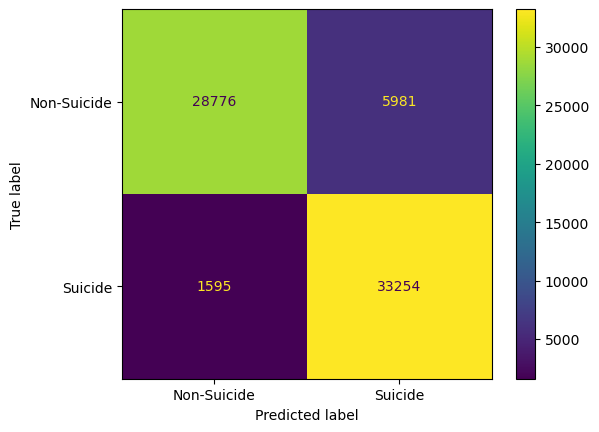

In [53]:
nb_confusion_matrix = metrics.confusion_matrix(test_y, y_pred_nb)

nb_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = nb_confusion_matrix, display_labels = ["Non-Suicide", "Suicide"])

nb_cm_display.plot()
plt.show()

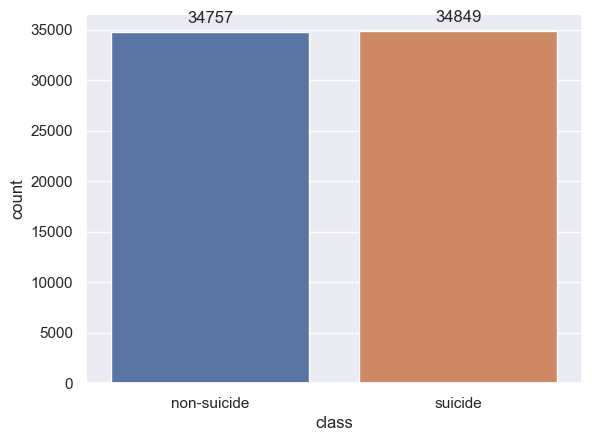

In [54]:
sns.set(style="darkgrid")
ax = sns.countplot(x=test_y)

for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()


In [55]:
# convert test_y and y_pred_logreg to numpy arrays
test_y = test_y.to_numpy()
y_pred_nb = np.array(y_pred_nb)

# find misclassified samples
nb_misclassified_indices = [i for i in range(len(test_y)) if test_y[i] != y_pred_nb[i]]
print(len(nb_misclassified_indices))

7576


In [56]:
# create a dataframe with test_X and their true and predicted labels
df_test_nb = pd.DataFrame({'text': test_X, 'true_label': test_y, 'predicted_label': y_pred_nb})

nb_misclassified_df = df_test_nb.iloc[nb_misclassified_indices]

In [57]:
nb_misclassified_df.head()

,text,true_label,predicted_label
28247,depressed_JJ definitely_RB ok_UH recently_RB f...,non-suicide,suicide
25193,help_NN someone_NN killed_VBN themself_RB meg_...,suicide,non-suicide
194706,please_UH think_VB say_UH something_NN online_...,non-suicide,suicide
213094,gain_NN confidence_NN around_RB people_NNS kno...,non-suicide,suicide
25688,professor_NN pulled_VBN aside_RB class_NN toda...,non-suicide,suicide


In [58]:
# merge misclassified_df with data based on the index
nb_misclassified_merged = pd.merge(nb_misclassified_df, data_text, left_index=True, right_index=True)

# print the misclassified texts, true labels, and predicted labels
nb_misclassified_merged_df = pd.DataFrame(nb_misclassified_merged[['text_y', 'true_label', 'predicted_label']])

In [59]:
nb_misclassified_merged_df.to_csv("misclassified_naive_bayes.csv")

### Logistic Regression

In [60]:
# fit the training dataset on the Logistic Regression classifier
logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train_tf,train_y)
# predict the labels on validation dataset
y_pred_logreg = logreg.predict(X_test_tf)

In [61]:
print(metrics.classification_report(test_y, y_pred_logreg, target_names=['Non-Suicide', 'Suicide']))

              precision    recall  f1-score   support

 Non-Suicide       0.93      0.95      0.94     34757
     Suicide       0.95      0.93      0.94     34849

    accuracy                           0.94     69606
   macro avg       0.94      0.94      0.94     69606
weighted avg       0.94      0.94      0.94     69606



In [62]:
print("Logistic Regression Accuracy Score -> ",accuracy_score(y_pred_logreg, test_y)*100)

Logistic Regression Accuracy Score ->  93.73329885354711


In [63]:
#Log Reg Confusion Matrix
print("Logistic Regression Confusion Matrix:")
print(metrics.confusion_matrix(test_y, y_pred_logreg))

Logistic Regression Confusion Matrix:
[[32919  1838]
 [ 2524 32325]]


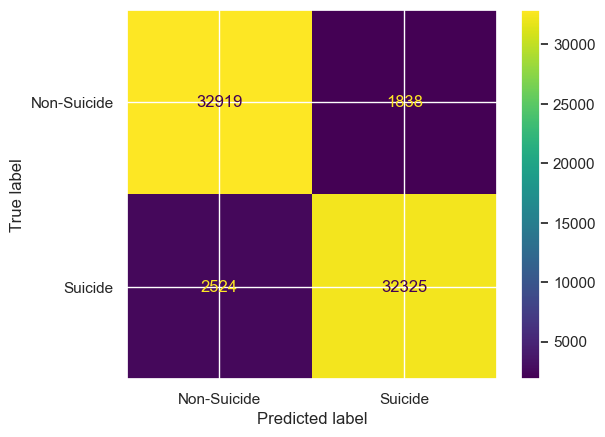

In [64]:
logreg_confusion_matrix = metrics.confusion_matrix(test_y, y_pred_logreg)

logreg_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = logreg_confusion_matrix, display_labels = ["Non-Suicide", "Suicide"])

logreg_cm_display.plot()
plt.show()

In [65]:
# convert test_y and y_pred_logreg to numpy arrays
y_pred_logreg = np.array(y_pred_logreg)

# find misclassified samples
logreg_misclassified_indices = [i for i in range(len(test_y)) if test_y[i] != y_pred_logreg[i]]
print(len(logreg_misclassified_indices))

4362


In [66]:
# create a dataframe with test_X and their true and predicted labels
df_test_logreg = pd.DataFrame({'text': test_X, 'true_label': test_y, 'predicted_label': y_pred_logreg})

logreg_misclassified_df = df_test_logreg.iloc[logreg_misclassified_indices]

In [67]:
logreg_misclassified_df.head()

,text,true_label,predicted_label
25193,help_NN someone_NN killed_VBN themself_RB meg_...,suicide,non-suicide
194706,please_UH think_VB say_UH something_NN online_...,non-suicide,suicide
664,adopt_VB mep_NN l_NN,suicide,non-suicide
44196,know_VB need_NN help_NN trust_NN anyone_NN exp...,suicide,non-suicide
169038,anyone_NN else_RB think_VB deserve_VB live_RB,non-suicide,suicide


In [68]:
# merge misclassified_df with data based on the index
logreg_misclassified_merged = pd.merge(logreg_misclassified_df, data_text, left_index=True, right_index=True)

# print the misclassified texts, true labels, and predicted labels
logreg_misclassified_merged_df = pd.DataFrame(logreg_misclassified_merged[['text_y', 'true_label', 'predicted_label']])

In [69]:
logreg_misclassified_merged_df.to_csv("misclassified_logistic_regression.csv")

### SVM

In [70]:
# fit the training dataset on the SVM classifier
linearSVC = LinearSVC()
linearSVC.fit(X_train_tf,train_y)
# predict the labels on validation dataset
y_pred_SVC = linearSVC.predict(X_test_tf)


In [71]:
print(metrics.classification_report(test_y, y_pred_SVC, target_names=['Non-Suicide', 'Suicide']))

              precision    recall  f1-score   support

 Non-Suicide       0.93      0.94      0.94     34757
     Suicide       0.94      0.93      0.94     34849

    accuracy                           0.94     69606
   macro avg       0.94      0.94      0.94     69606
weighted avg       0.94      0.94      0.94     69606



In [72]:
print("SVM Accuracy Score -> ",accuracy_score(y_pred_SVC, test_y)*100)

SVM Accuracy Score ->  93.61118294399908


In [73]:
#SVM Confusion Matrix
print("Logistic Regression Confusion Matrix:")
print(metrics.confusion_matrix(test_y, y_pred_SVC))

Logistic Regression Confusion Matrix:
[[32782  1975]
 [ 2472 32377]]


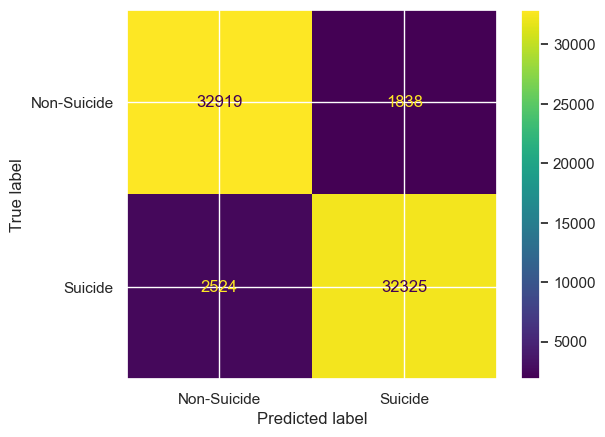

In [74]:
svc_confusion_matrix = metrics.confusion_matrix(test_y, y_pred_SVC,)

svc_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = svc_confusion_matrix, display_labels = ["Non-Suicide", "Suicide"])

logreg_cm_display.plot()
plt.show()

In [75]:
# convert test_y and y_pred_logreg to numpy arrays
y_pred_SVC = np.array(y_pred_SVC)

# find misclassified samples
svc_misclassified_indices = [i for i in range(len(test_y)) if test_y[i] != y_pred_SVC[i]]
print(len(svc_misclassified_indices))

4447


In [76]:
# create a dataframe with test_X and their true and predicted labels
df_test_SVC = pd.DataFrame({'text': test_X, 'true_label': test_y, 'predicted_label': y_pred_SVC})

SVC_misclassified_df = df_test_SVC.iloc[svc_misclassified_indices]

In [77]:
SVC_misclassified_df.head()

,text,true_label,predicted_label
25193,help_NN someone_NN killed_VBN themself_RB meg_...,suicide,non-suicide
194706,please_UH think_VB say_UH something_NN online_...,non-suicide,suicide
664,adopt_VB mep_NN l_NN,suicide,non-suicide
44196,know_VB need_NN help_NN trust_NN anyone_NN exp...,suicide,non-suicide
169038,anyone_NN else_RB think_VB deserve_VB live_RB,non-suicide,suicide


In [78]:
# merge misclassified_df with data based on the index
SVC_misclassified_merged = pd.merge(SVC_misclassified_df, data_text, left_index=True, right_index=True)

# print the misclassified texts, true labels, and predicted labels
SVC_misclassified_merged_df = pd.DataFrame(SVC_misclassified_merged[['text_y', 'true_label', 'predicted_label']])

In [79]:
SVC_misclassified_merged_df.to_csv("misclassified_SVM.csv")

In [80]:
#sample prediction
test = ['i want to die. cannot live any longer. help']

In [81]:
review = re.sub('[^a-zA-Z]', ' ', test[0])
review = review.lower()
review = review.split()
stop_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
review = [lemmatizer.lemmatize(word) for word in review if not word in stop_list]

In [82]:
# Create a function to add POS tags in the form of word_POS
def add_pos_tag(sentences):
    tagged_sentences = []
    for sentence in sentences:
        # Tokenize sentence into words
        words = nltk.word_tokenize(sentence)
        # Get POS tags for words
        pos_tags = nltk.pos_tag(words)
        # Join word and POS tag into word_POS format
        tagged_words = [f"{word}_{pos}" for word, pos in pos_tags]
        # Join tagged words into sentence
        tagged_sentence = " ".join(tagged_words)
        # Add tagged sentence to list
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences

test_tagged = add_pos_tag(review)
print(test_tagged)

['want_NN', 'die_NN', 'can_MD not_RB', 'live_JJ', 'longer_NN', 'help_NN']


In [83]:
test_processed =[ ' '.join(test_tagged)]
test_processed

['want_NN die_NN can_MD not_RB live_JJ longer_NN help_NN']

In [84]:
test_input = tf_idf.transform(test_processed)
test_input.shape

(1, 44823)

In [85]:
#Naive Bayes
nb_result = naive_bayes_classifier.predict(test_input)[0]
nb_result

'suicide'

In [86]:
#LogReg
logreg_result = logreg.predict(test_input)[0]
logreg_result

'suicide'

In [87]:
#SVM
SVC_result = linearSVC.predict(test_input)[0]
SVC_result

'suicide'